# PASO 8: LIMITACIONES DE RECURSOS SEGÚN TABLA

In [ ]:
# DATOS

import pandas as pd

df = pd.read_csv('P_C05-1C2025_data.csv', sep = ';')

nec = {}

for _, fila in df.iterrows():
    nec.update({(fila.LOT, fila.PRODUCT): fila.QTY} )

In [2]:
# MODELO

prod = {
    'Y4W': 
    {
    'corte_m1': 0,
    'corte_m2': 0,
    'doblado': 0,
    'soldado': 0,
    'corte_w': 23,
    'tapizado': 0,
    'pintura': 15,
    'despacho': 24
    },
    'Q79': 
    {
    'corte_m1': 45,
    'corte_m2': 40,
    'doblado': 23,
    'soldado': 32,
    'corte_w': 34,
    'tapizado': 102,
    'pintura': 36,
    'despacho': 34
    },
    'VEQ': 
    {
    'corte_m1': 48,
    'corte_m2': 43,
    'doblado': 38,
    'soldado': 56,
    'corte_w': 0,
    'tapizado': 0,
    'pintura': 36,
    'despacho': 20
    }
}

op = ['corte_m1','corte_m2','doblado','soldado','corte_w','tapizado','pintura','despacho']

ultima_op = 'despacho'

from docplex.cp.model import CpoModel, CpoStepFunction

m = CpoModel()

ope = []


# definicion de calendario ******
dic = CpoStepFunction()

horizonte = 500000 

dic.set_value(0, horizonte, 0)          # carga 1000 horas todas al 0%

s = 0
for j in range(0, horizonte, 24):
    if s<5:
        for k in range(j+8, j+17):
            dic.set_value(k, k+1, 100)
        dic.set_value(j+12, j+13, 0)    # almuerzo
    s = s + 1
    if s == 7: s = 0




# intervalos
for i in nec:
    r = []
    for j in op:      
        r.append(m.interval_var(optional = True, intensity=dic, size = prod[i[1]][j]*nec[i], name = i[0] + '_' + i[1] + '_' +  j ))
    ope.append(r)

# relaciones de precedencia
for i in nec:
    idx = list(nec.keys()).index(i) # consulta de stackoverflow
    if i[1] == 'Y4W':   # estanteria de madera
        m.add(m.presence_of(ope[idx][op.index('corte_m1')])==0)
        m.add(m.presence_of(ope[idx][op.index('corte_m2')])==0)
        m.add(m.presence_of(ope[idx][op.index('doblado')])==0)
        m.add(m.presence_of(ope[idx][op.index('soldado')])==0)
        m.add(m.presence_of(ope[idx][op.index('corte_w')])==1)
        m.add(m.presence_of(ope[idx][op.index('tapizado')])==0)
        m.add(m.presence_of(ope[idx][op.index('pintura')])==1)
        m.add(m.presence_of(ope[idx][op.index('despacho')])==1)
        m.add(m.end_before_start(ope[idx][op.index('corte_w')], ope[idx][op.index('pintura')]))
        m.add(m.end_before_start(ope[idx][op.index('pintura')], ope[idx][op.index('despacho')], 24*60))

    if i[1] == 'Q79':   # silla combinada
        m.add(m.presence_of(ope[idx][op.index('corte_m1')]) + m.presence_of(ope[idx][op.index('corte_m2')]) ==1)
        m.add(m.presence_of(ope[idx][op.index('doblado')])==1)
        m.add(m.presence_of(ope[idx][op.index('soldado')])==1)
        m.add(m.presence_of(ope[idx][op.index('corte_w')])==1)
        m.add(m.presence_of(ope[idx][op.index('tapizado')])==1)
        m.add(m.presence_of(ope[idx][op.index('pintura')])==1)
        m.add(m.presence_of(ope[idx][op.index('despacho')])==1)        
        m.add(m.end_before_start(ope[idx][op.index('corte_m1')], ope[idx][op.index('doblado')]))
        m.add(m.end_before_start(ope[idx][op.index('corte_m2')], ope[idx][op.index('doblado')]))
        m.add(m.end_before_start(ope[idx][op.index('doblado')], ope[idx][op.index('soldado')]))        
        m.add(m.end_at_start(ope[idx][op.index('soldado')], ope[idx][op.index('pintura')]))  
        m.add(m.end_before_start(ope[idx][op.index('pintura')], ope[idx][op.index('despacho')], 24*60))
        m.add(m.end_before_start(ope[idx][op.index('corte_w')], ope[idx][op.index('tapizado')]))
        m.add(m.end_before_start(ope[idx][op.index('tapizado')], ope[idx][op.index('despacho')]))
    if i[1] == 'VEQ':   # silla de metal  
        m.add(m.presence_of(ope[idx][op.index('corte_m1')]) + m.presence_of(ope[idx][op.index('corte_m2')]) ==1)
        m.add(m.presence_of(ope[idx][op.index('doblado')])==1)
        m.add(m.presence_of(ope[idx][op.index('soldado')])==1)
        m.add(m.presence_of(ope[idx][op.index('corte_w')])==0)
        m.add(m.presence_of(ope[idx][op.index('tapizado')])==0)
        m.add(m.presence_of(ope[idx][op.index('pintura')])==1)
        m.add(m.presence_of(ope[idx][op.index('despacho')])==1)
        m.add(m.end_before_start(ope[idx][op.index('corte_m1')], ope[idx][op.index('doblado')]))
        m.add(m.end_before_start(ope[idx][op.index('corte_m2')], ope[idx][op.index('doblado')]))
        m.add(m.end_before_start(ope[idx][op.index('doblado')], ope[idx][op.index('soldado')]))        
        m.add(m.end_at_start(ope[idx][op.index('soldado')], ope[idx][op.index('pintura')]))  
        m.add(m.end_before_start(ope[idx][op.index('pintura')], ope[idx][op.index('despacho')], 24*60))

# agrupacion (span)
lot = []
for i in nec:
    lot.append(m.interval_var(name = i[0]))

for l in range(len(lot)):
    m.add(m.span(lot[l], [ope[l][j] for j in range(len(op))]))

# limitaciones de recursos
m.add(  m.sum(   m.pulse(ope[i][op.index('corte_m1')],1) for i in range(len(nec))     )  <= 1)
m.add(  m.sum(   m.pulse(ope[i][op.index('corte_m2')],1) for i in range(len(nec))     )  <= 1)
m.add(  m.sum(   m.pulse(ope[i][op.index('doblado')],1) for i in range(len(nec))     )  <= 1)
m.add(  m.sum(   m.pulse(ope[i][op.index('soldado')],1) for i in range(len(nec))     )  <= 2)
m.add(  m.sum(   m.pulse(ope[i][op.index('corte_w')],1) for i in range(len(nec))     )  <= 2)
m.add(  m.sum(   m.pulse(ope[i][op.index('tapizado')],1) for i in range(len(nec))     )  <= 1)
m.add(  m.sum(   m.pulse(ope[i][op.index('pintura')],1) for i in range(len(nec))     )  <= 1)
m.add(  m.sum(   m.pulse(ope[i][op.index('despacho')],1) for i in range(len(nec))     )  <= 3)


# funcional
m.add( m.minimize(m.max(m.end_of(ope[i][op.index(ultima_op)]) for i in range(len(nec)))))


# resolución
s = m.solve()

s.print_solution()



 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 126 variables, 194 constraints
 ! Presolve      : 9 extractables eliminated
 ! Initial process time : 0.08s (0.08s extraction + 0.00s propagation)
 !  . Log search space  : 529.4 (before), 529.4 (after)
 !  . Memory usage      : 5.2 MB (before), 5.2 MB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        126                 -
 + New bound is 106378
 ! Using iterative diving.
 *        341415      170  0.26s        1      (gap is 68.84%)
 *        339711      511  0.26s        1      (gap is 68.69%)
          339711     1000          2    1     178714  = startOf(L-0513_VEQ_despacho)
          339711     2000         12    1     221369  = endOf(L-0518_Y4W_despacho)
          339711     3000         15    1   F    

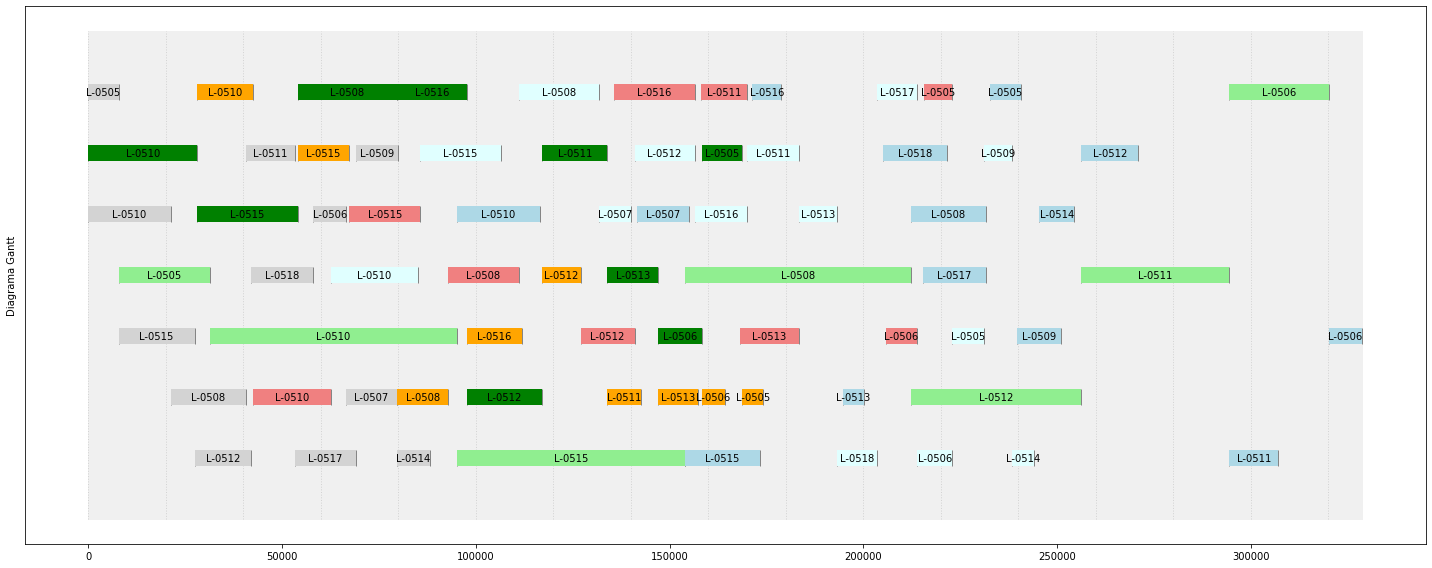

In [4]:
# GRAFICO DE GANTT 

import docplex.cp.utils_visu as visu

color = ['green','yellow','orange','lightcoral','lightgrey','lightgreen','lightcyan', 'lightblue']
op =    ['corte_m1','corte_m2','doblado','soldado','corte_w','tapizado','pintura','despacho']

from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

visu.pause(dic) # ****** inclusión del calendario en el gráfico
visu.naming(lambda name: name[0:6])  
visu.panel(name='Diagrama Gantt')

for i in range(len(nec)):
    for j in range(len(op)):           
        if s.get_var_solution(ope[i][j]).is_present(): visu.interval(s.get_var_solution(ope[i][j]), color[j], ope[i][j].name)

visu.show()
